In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

In [2]:
def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function gathers curriculum_logs data from the 
    SQL codeup database and returns the information in a 
    pandas dataframe
    '''
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [3]:
def one_user_df_prep(df, user, the_resample = 'd'):
    '''
    This function takes a user number and returns all instances of that
    specific user in a pandas dataframe
    '''
    df = df[df.user_id == user].copy()
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    df = df.sort_index()
    pages_one_user = df['endpoint'].resample(the_resample).count()
    return pages_one_user

In [4]:
def compute_pct_b(pages_one_user, span, k, user):
    '''
    This function gets an average between the span the user
    inputs and gathers the mean for a midband
    It then gets the upper and lower bulinger bands based off of 
    the K or number of standard deviations from the midband
    and returns the information in a pandas dataframe
    '''
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*k
    lb = midband - stdev*k
    
    my_df = pd.concat([pages_one_user, midband, ub, lb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [51]:
def plot_bands_2(my_df, user):
    '''
    This function plots the upper and lower bulinger band. 
    As well as the midband and the number of pages viewed
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
#     plt.show()
    return ax

In [52]:
def plot_bands(my_df, user):
    '''
    This function plots the upper and lower bulinger band. 
    As well as the midband and the number of pages viewed
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()


In [59]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function runs the other functions and returns
    dataframes containing the anomalies that are above and
    below the upper and lower bolinger bands
    '''
    pages_one_user = one_user_df_prep(df, user)
    
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    if plot:
        plot_bands(my_df, user)
    
    return my_df[my_df.pct_b>1], my_df[my_df.pct_b<0]

In [24]:
df = acquire_logs()

In [43]:
user=2
span=30
k=3

/var/folders/9q/9mllqnsn2vq07btq58zw9zzc0000gn/T/ipykernel_3250/1346574670.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,3, i +1)
/var/folders/9q/9mllqnsn2vq07btq58zw9zzc0000gn/T/ipykernel_3250/1346574670.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,3, i +1)
/var/folders/9q/9mllqnsn2vq07btq58zw9zzc0000gn/T/ipykernel_3250/1346574670.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,3, i +1)
/var/folders/9q/9mllqnsn2vq07btq58zw9zzc0000gn/T/ipykernel_3250/1346574670.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.

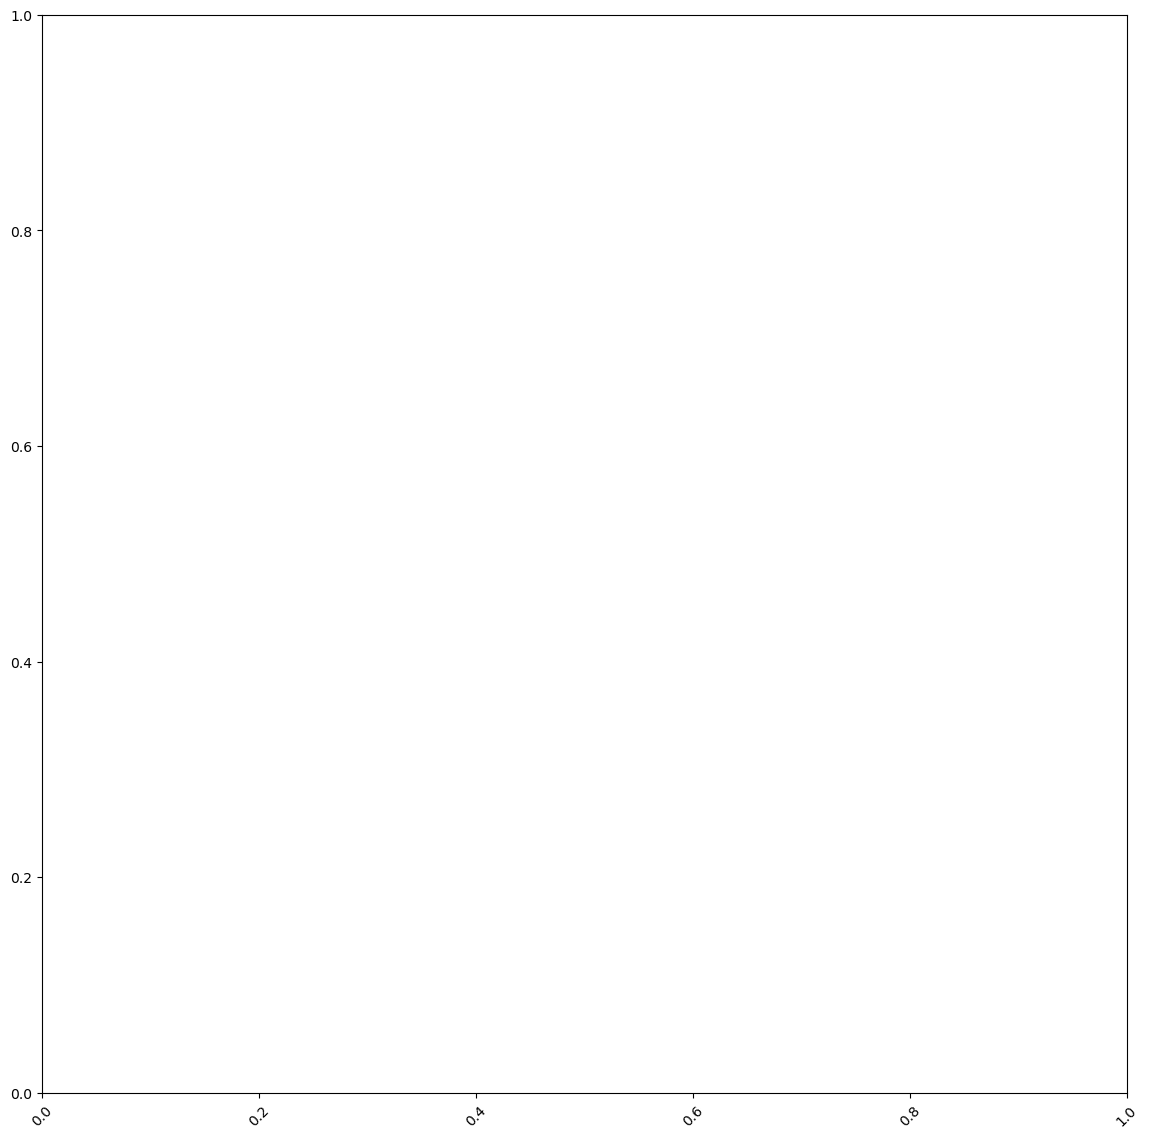

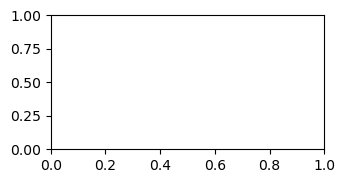

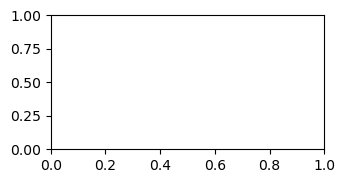

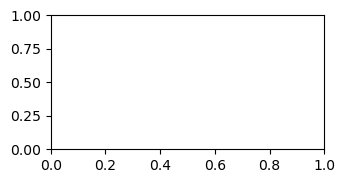

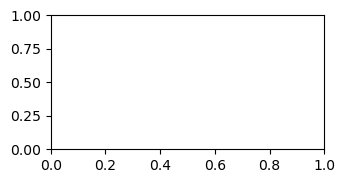

In [62]:
plt.figure(figsize=(14,14))
plt.xticks(rotation = 45)
user=1
for i in df.user_id.unique():
    if i < 5:
        df_1, df_2 = find_anomalies(df, user, span, weight = k)
        plot_bands_2(df_1, user)
        plt.subplot(4,3, i +1)
        user+=1
        
    
plt.show()

